In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

In [2]:
import string
# Ruta del dataset
dataset_path = 'dades'

# Crear un mapeo de caracteres válidos (0-9 y A-Z)
valid_characters = list(string.digits + string.ascii_uppercase)  # ['0', '1', ..., '9', 'A', ..., 'Z']
char_to_index = {char: idx for idx, char in enumerate(valid_characters)}  # {'0': 0, ..., 'A': 10, ..., 'Z': 35}

# Inicializar listas para imágenes y etiquetas
images = []
labels = []

# Recorrer las subcarpetas
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):  # Verificar si es una carpeta
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            # Cargar la imagen en escala de grises
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image.shape[0] != 32 or image.shape[1] != 32:
                # Redimensionar la imagen al tamaño esperado por el modelo
                image = cv2.resize(image, (32, 32))
            # Normalizar la imagen
            normalized_image = image / 255.0
            # Expandir dimensiones para que coincida con el formato esperado por el modelo
            input_image = np.expand_dims(normalized_image, axis=-1)
            # Agregar la imagen y la etiqueta a las listas
            images.append(input_image)
            # Convertir etiquetas alfanuméricas a enteros únicos
            labels.append(char_to_index[label])  # Usar el índice mapeado como etiqueta

# Convertir las listas a arrays de NumPy
images = np.array(images)
labels = np.array(labels)

# Total de imágenes y etiquetas
print(f"Total de imágenes: {len(images)}")
print(f"Total de etiquetas: {len(labels)}")

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convertir las etiquetas a one-hot encoding
y_train = to_categorical(y_train, num_classes=36)
y_test = to_categorical(y_test, num_classes=36)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_test: {y_test.shape}")

Total de imágenes: 3600
Total de etiquetas: 3600
Forma de X_train: (2880, 32, 32, 1)
Forma de y_train: (2880, 36)
Forma de X_test: (720, 32, 32, 1)
Forma de y_test: (720, 36)


In [3]:
import keras_tuner as kt

def build_model(hp):
    """Define el modelo con hiperparámetros ajustables."""
    model = models.Sequential()
    
    # Optimizando la primera capa convolucional
    filters_1 = hp.Int('filters_1', min_value=16, max_value=64, step=16)
    kernel_size_1 = hp.Choice('kernel_size_1', values=[3, 5])
    
    model.add(layers.Conv2D(filters_1, (kernel_size_1, kernel_size_1), 
                           activation='relu', 
                           input_shape=(32, 32, 1), 
                           padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    # Optimizando la segunda capa convolucional
    filters_2 = hp.Int('filters_2', min_value=32, max_value=128, step=32)
    kernel_size_2 = hp.Choice('kernel_size_2', values=[3, 5])
    
    model.add(layers.Conv2D(filters_2, (kernel_size_2, kernel_size_2), 
                           activation='relu', 
                           padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    # Capas adicionales convolucionales (opcional)
    if hp.Boolean('add_third_conv'):
        filters_3 = hp.Int('filters_3', min_value=64, max_value=256, step=64)
        model.add(layers.Conv2D(filters_3, (3, 3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    model.add(layers.Flatten())
    
    # Optimizando capas densas
    units_1 = hp.Int('units_1', min_value=500, max_value=1500, step=250)
    model.add(layers.Dense(units_1, activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Segunda capa densa (opcional)
    if hp.Boolean('add_second_dense'):
        units_2 = hp.Int('units_2', min_value=250, max_value=1000, step=250)
        model.add(layers.Dense(units_2, activation='relu'))
        model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Capa de salida
    model.add(layers.Dense(36, activation='softmax'))
    
    # Optimizando el optimizador
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [4]:
# Configurar el tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='keras_tuner_dir',
    project_name='ocr_character_recognition'
)

c:\Users\rosel\Documents\IA-BD\PIA\Proyecto2-Parquing\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Ejecutar la búsqueda
tuner.search(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Trial 30 Complete [00h 00m 15s]
val_accuracy: 0.03055555559694767

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 07m 47s


In [7]:
# Obtener el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]

# Mostrar resumen de resultados
tuner.results_summary()

Results summary
Results in keras_tuner_dir\ocr_character_recognition
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0013 summary
Hyperparameters:
filters_1: 32
kernel_size_1: 3
filters_2: 32
kernel_size_2: 5
add_third_conv: True
units_1: 1500
dropout_1: 0.2
add_second_dense: True
optimizer: adam
learning_rate: 0.001
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
filters_3: 64
units_2: 250
dropout_2: 0.2
tuner/trial_id: 0000
Score: 1.0

Trial 0016 summary
Hyperparameters:
filters_1: 32
kernel_size_1: 3
filters_2: 32
kernel_size_2: 5
add_third_conv: True
units_1: 1500
dropout_1: 0.2
add_second_dense: True
optimizer: adam
learning_rate: 0.001
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
filters_3: 64
units_2: 250
dropout_2: 0.2
tuner/trial_id: 0013
Score: 1.0

Trial 0017 summary
Hyperparameters:
filters_1: 48
kernel_size_1: 5
filters_2: 32
kernel_size_2: 5
add_third_conv: True
units_1: 1000
dropout_1: 0.3000

In [8]:
# Evaluar el modelo en el conjunto de prueba
evaluation = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0071
Test Loss: 0.007385315373539925, Test Accuracy: 1.0


In [9]:
# Guardar el mejor modelo
best_model.save('../best_caracter_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
best_model = load_model('best_caracter_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


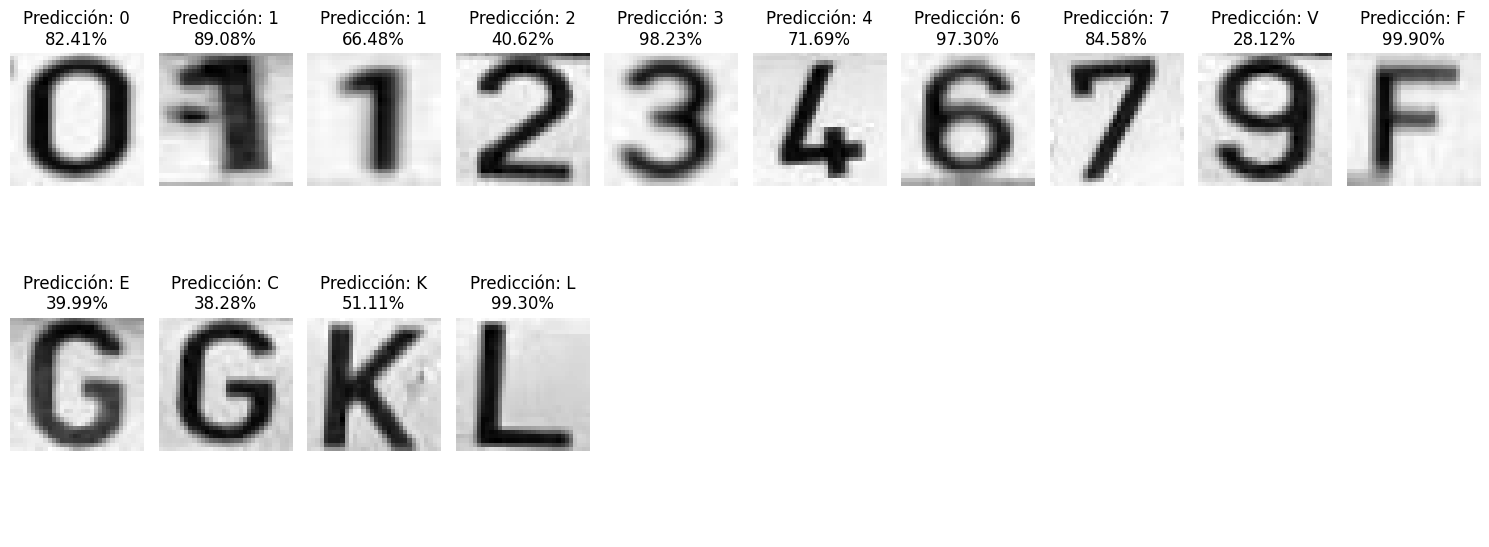

In [11]:
# Definir la ruta de la carpeta de imágenes de prueba
test_folder_path = '../char-test'

# Obtener la lista de imágenes de prueba
test_images = [os.path.join(test_folder_path, f) for f in os.listdir(test_folder_path) if f.endswith('.jpg')]

# Crear un subplot para mostrar todas las imágenes de prueba y sus predicciones
rows = (len(test_images) + 9) // 10  # Calcular el número de filas necesarias
fig, axes = plt.subplots(rows, min(len(test_images), 10), figsize=(15, 3 * rows))

# Asegurarse de que 'axes' sea un arreglo bidimensional
if rows == 1:
    axes = np.expand_dims(axes, axis=0)

# Iterar sobre las imágenes de prueba
for idx, test_image_path in enumerate(test_images):
    row, col = divmod(idx, 10)
    # Cargar la imagen en escala de grises
    test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    
    # Redimensionar la imagen al tamaño esperado por el modelo
    resized_test_image = cv2.resize(test_image, (32, 32))
    
    # Normalizar la imagen
    normalized_test_image = resized_test_image / 255.0
    
    # Expandir dimensiones para que coincida con el formato esperado por el modelo
    test_input = np.expand_dims(normalized_test_image, axis=(0, -1))
    
    # Realizar la predicción
    prediction = best_model.predict(test_input)
    
    # Obtener el índice de la clase con mayor probabilidad
    predicted_class = np.argmax(prediction)
    
    # Convertir el índice a su carácter correspondiente
    predicted_character = valid_characters[predicted_class]
    
    # Calcular el nivel de confianza de la predicción
    confidence = np.max(prediction) * 100
    
    # Mostrar la imagen y la predicción en el subplot correspondiente
    axes[row, col].imshow(resized_test_image, cmap='gray')
    axes[row, col].set_title(f'Predicción: {predicted_character}\n{confidence:.2f}%')
    axes[row, col].axis('off')

# Ocultar subplots vacíos si los hay
for idx in range(len(test_images), rows * 10):
    row, col = divmod(idx, 10)
    axes[row, col].axis('off')

# Ajustar el diseño del subplot
plt.tight_layout()
plt.show()